# Calculating NDVI

Normalized Digital Vegetation Index [(NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) is an important metric for analyzing plant health, equal to the normalized difference between the Near-infrared band and the red band. This metric corresponds to high values for healthy plant life, and low values for low amounts of plant cover. In this tutorial, we will analyze the NDVI of the area surrounding Elkton, Virginia.

We make the usual imports and declarations.

In [1]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
from pyspark.sql import *
from pyspark.sql.functions import udf
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
resource_dir = Path('./samples').resolve()

def readTiff(renamed, band):
    return spark.read.geotiff(resource_dir.joinpath('L8-B{}-Elkton-VA.tiff'.format(band)) \
    .as_uri()).withColumnRenamed('tile', '{}_band'.format(renamed)).asRF()

NDVI is calculated using the red and near-infrared bands, so those must be read in.

In [2]:
redBand = readTiff("red", 4)
nirBand = readTiff("nir", 5)

Here's an example of computing the Normalized Differential Vegetation Index. (NDVI) is a 
standardized vegetation index which allows us to generate an image highlighting differences in
relative biomass. 

> “An NDVI is often used worldwide to monitor drought, monitor and predict agricultural production, assist in predicting hazardous fire zones, and map desert encroachment. The NDVI is preferred for global vegetation monitoring because it helps to compensate for changing illumination conditions, surface slope, aspect, and other extraneous factors” (Lillesand. *Remote sensing and image interpretation*. 2004).

NDVI is the normalized difference of the nir and red bands:
$$ NDVI = \frac{nir - red}{nir + red}$$

In [3]:
rf = redBand.asRF().spatialJoin(nirBand.asRF()) \
    .withColumn("ndvi", normalizedDifference(convertCellType('nir_band', 'float32'), convertCellType('red_band', 'float32'))).asRF()
rf.select(tileStats('ndvi')).show(1, False)

+------------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                           |
+------------------------------------------------------------------------------------------+
|[31433,-1,-0.12488999217748642,0.669983446598053,0.45558948037343605,0.010907294557452653]|
+------------------------------------------------------------------------------------------+



In [4]:
rf.select(cellType('ndvi')).show()

+------------------------+
|celltypeexpression(ndvi)|
+------------------------+
|                 float32|
+------------------------+



In order to reshape our image data into a 2d numpy array we must know its dimensions. This is in [column, row] format.

In [5]:
rf.select(tileDimensions('ndvi')).show()

+---------------+
|dimension(ndvi)|
+---------------+
|      [186,169]|
+---------------+



To prepare the image for plotting, we convert it to a 2 dimensional numpy array.

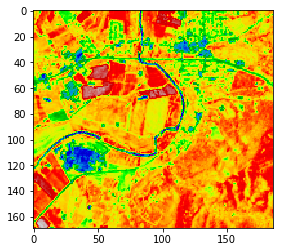

In [6]:
pixels = np.reshape(np.asarray(rf.select(tileToDoubleArray('ndvi')).first()), (169, 186))

imgplot = plt.imshow(pixels)
imgplot.set_cmap('nipy_spectral')